<a href="https://colab.research.google.com/github/rebeccahe1998/E4511-2021-HE/blob/main/explore_data_excape_min_viable_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring SLC6A3 protein target activity data from ExcapeDB

The Target specific data was downloaded from https://zenodo.org/record/173258#.X_44kuhKi70



In [1]:
!date # starting time

Wed Mar 17 21:05:39 UTC 2021


## Install AMPL GPU version

```
real	2m59.739s
user	1m48.995s
sys	0m20.614s
```

In [ ]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh


In [3]:
!date

Wed Mar 17 21:12:23 UTC 2021


## Exploring target activity data from selected database
## Data source = ExcapeDB
## Target activity for the receptor SLC6A3


In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')
import json
import requests

In [5]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

## Select a target to work with 


# Define data locations 
## This data has 'rdkit_base_smiles' and drooped the empty rows.

In [6]:
! wget https://github.com/rebeccahe1998/E4511-2021-HE/raw/main/EXCAPE_SLC6A3_SMILES.csv

--2021-03-17 21:13:01--  https://github.com/rebeccahe1998/E4511-2021-HE/raw/main/EXCAPE_SLC6A3_SMILES.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/EXCAPE_SLC6A3_SMILES.csv [following]
--2021-03-17 21:13:01--  https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/EXCAPE_SLC6A3_SMILES.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21337302 (20M) [text/plain]
Saving to: ‘EXCAPE_SLC6A3_SMILES.csv’

EXCAPE_SLC6A3_SMILE 100%[===================>]  20.35M  98.4MB/s    in 0.2s    

2021-03-17 21:13:02 (98.4 MB/s) - ‘EXCAPE_SLC6A3_SMILES.csv’ save

In [7]:
# Reading the downloaded content and turning it into a pandas dataframe
orig_df = pd.read_csv('EXCAPE_SLC6A3_SMILES.csv')


In [8]:
orig_df=orig_df.drop(columns=orig_df.iloc[:,0:2])

In [9]:
print(sum(orig_df['pXC50'].isna()) )
print(len(orig_df) - sum(orig_df['pXC50'].isna()))
# it is probably not a good idea if i have 100k of empty value for pXC50
len(orig_df)

106523
5292


111815

### Load target data into a pandas data frame

In [10]:
# orig_df=pd.read_csv(file,sep="\t",engine="python",error_bad_lines=False)
#show number of rows in data frame and number of columns
print(orig_df.shape)

# show column names
display(orig_df.columns)

(111815, 12)


Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES', 'base_rdkit_smiles'],
      dtype='object')

In [11]:
display(orig_df)

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
0,CHSINHUYLALJPT-UHFFFAOYNA-N,9549512,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,N1(C2CCCCCC2)CCNCC1,C1CCCC(N2CCNCC2)CC1
1,SBIGSHCJXYGFMX-UHFFFAOYNA-N,1778877,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O(C(=O)CCCCCCCC=C)C,C=CCCCCCCCC(=O)OC
2,STHIZMRUXPMSCW-UHFFFAOYNA-N,123435,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O1CCNCCOCCOCCNCC1,C1COCCNCCOCCOCCN1
3,XVFVMXHZBURBPL-UHFFFAOYNA-N,3245471,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O=C1N(CN2CCCCC2)CCC1,O=C1CCCN1CN1CCCCC1
4,AVNGLLNZZQWRFA-UHFFFAOYNA-N,16060801,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O=C1CCN(CCCCCCC)C=C1,CCCCCCCN1C=CC(=O)CC1
...,...,...,...,...,...,...,...,...,...,...,...,...
111810,ZGGHYOXCALXKMG-SLNAITDINA-N,CHEMBL411570,24898,N,3.74,chembl20,376175,10116,SLC6A3,4060,C(=O)([C@@H](N)CC1=CC=C2C(=C1)C=CC=C2)N[C@H](C...,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...
111811,AZSRBVAPBFWEGT-GUOYQLOPNA-N,CHEMBL1200633,6531,A,5.45,chembl20,774754,9606,SLC6A3,4060,C1=2[C@]3([C@H](OCC3=CC=C[C@@H]([C@H](O[C@@H]4...,CC[C@H](C)[C@H]1O[C@]2(CC[C@@H]1C)C[C@@H]1C[C@...
111812,CMZQTQQNYUMUAL-DBFFLIBTNA-N,CHEMBL383931,24898,N,3.76,chembl20,376175,10116,SLC6A3,4060,N(C([C@@H](NC([C@@H](NC([C@H]1N(CCC1)C([C@@H](...,C[C@H](NC(=O)[C@@H](N)Cc1ccc(-c2ccc(C[C@H](N)C...
111813,MGKWXTIOHURCAH-FSJJVWPSNA-N,CHEMBL374492,24898,A,6.60,chembl20,376182,10116,SLC6A3,4060,C(=O)(O)[C@@H](N)CC=1C=CC(C=2C=CC(=CC2)C([C@H]...,CC(c1ccc(-c2ccc(C[C@H](N)C(=O)O)cc2)cc1)[C@H](...


## For ExCAPE-DB Drop all pxc 50 with null values

In [47]:
save_df=orig_df

save_df = save_df[save_df['pXC50'].notna()]
len(save_df)
sum(save_df['base_rdkit_smiles'].isna()) # there is no empty rdkit smiles
save_df.to_csv('EXCAPE_SLC6A3_SMILES_DROPNA')

## What does get.smiles_excape_data function do? 

*   Expects a 'pXC50' column
*   Applies **dropna** to `pXC50` column
*   standardizes by calling **struct_utils.base_smiles_from_smiles** and converts **SMILES** column and writes it out as a new column called **rdkit_smiles** 
** Will return a list that contains a DF (with added column, **rdkit_smiles** and a list of InChiKey

In [ ]:
# there is already rdkiut smiles
# slst,klst=dcf.get_smiles_excape_data(save_df,[target_name])
# save_smiles_df=slst[0]

HTR3A distinct compounds = only 605
(649, 13)
605


## If needed, create smaller dataset

In [17]:
# comment the following two code lines in system with memory constraints or for testing
# make a copy 
save_smiles_df = save_df
save_smiles_df_copy = save_smiles_df
save_smiles_df = save_smiles_df.sample(frac=0.5, random_state=1)

In [18]:
## We need to save this format with the RDKIT conanonical SMILES
save_smiles_df.to_csv("frac_excape.csv",index=False)

### Now the PIC50 column is created above with this function call

# Export this Image to a  PNG to upload to slide deck for comparison


Post-processing dataset

Total Number of results = 2646
dataset mean = 6.782279225245649 NM
dataset stdev = 1.2218949422698102 NM
dataset max = 11.7 NM
dataset min = 2.55 NM



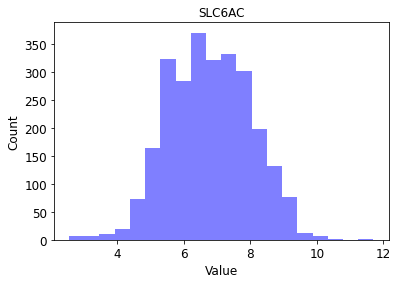

In [19]:
# Our outcome is pXC50 
column = 'pXC50'

# num_bins wil decide how many bins for creating histogram plot
num_bins = 20

target_name = 'SLC6AC'
# Ue the target_name as the title for the plot 
title = target_name

# Outcome data units (nanomolar = nm = $1 x 10^-9$ M )
units = 'NM'

# filepath, in this case, current dir
filepath = ""

# save_smiles_df was defined earlier
data=save_smiles_df

# call AMPL function (mouse over the function call and view source to see the code)
# The curate_data.summarize_data will summarize the data 
# output will be: 
# Total Number of results (data rows)
#   dataset mean: (mean of pXC50)
#   dataset stdev: (sd of pXC50)
#   dataset max: max value of data
#   dataset min: min value of data
curate_data.summarize_data(column, num_bins, title, units, filepath, data)

In [21]:
data.rename( columns={ "Ambit_InchiKey" : "compound_id" }, inplace=True)

curated_file = "frac_excape.csv"
data.head(5)

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
26055,XXPANQJNYNUNES-UHFFFAOYNA-N,CHEMBL273575,6531,A,8.00000,chembl20,939923,9606,SLC6A3,4060,C12=C(C(C3=CC=CC=C3)CN(C1)C)C=CC=C2N,CN1Cc2c(N)cccc2C(c2ccccc2)C1
84901,ZPUCINDJVBIVPJ-NEXFUWMNNA-N,CHEMBL2112004,24898,A,7.05000,chembl20,61983,10116,SLC6A3,4060,C12[C@H]([C@H](OC(=O)C3=CC=CC=C3)CC(N1C)CC2)C(...,COC(=O)[C@@H]1C2CCC(C[C@H]1OC(=O)c1ccccc1)N2C
32408,KYFGACYORZGXNM-CHWSQXEVNA-N,52943609,24898,A,7.85387,pubchem,515950,10116,SLC6A3,4060,IC1=CC=C([C@H]([C@@H]2NCCCC2)C(OC)=O)C=C1,COC(=O)[C@H](c1ccc(I)cc1)[C@H]1CCCCN1
105563,XTEKMJCKVNQZRJ-WVEVRRLPNA-N,CHEMBL333331,6531,A,7.04000,chembl20,61354,9606,SLC6A3,4060,C12C([C@@H](OC(C=3C=CC(=CC3)Cl)C=4C=CC(=CC4)Cl...,COC(=O)C1C2CCC(C[C@@H]1OC(c1ccc(Cl)cc1)c1ccc(C...
105990,WYJIEKRDCVWTRP-HJLBWTBNNA-N,CHEMBL607051,24898,A,8.63000,chembl20,61819,10116,SLC6A3,4060,C1(C2C3N(C)[C@@H](C[C@@H]2C4=CC=C(C=C4)C)CC3)=...,Cc1ccc([C@H]2C[C@H]3CCC(C2c2nc(-c4ccccc4)no2)N...


In [23]:
# column: Response values column
column = 'pXC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'base_rdkit_smiles'

# column that will be averaged ; smiles_col; used to find the replicates
# 

curated_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)
# curated_file = os.path.join(working_dir, ofile)
## discard out of range values
curated_df=curated_df[curated_df['VALUE_NUM_mean']>2]
curated_df.to_csv(curated_file, index=False)
curated_df.head()

Bad duplicates removed from dataset
Dataframe size (2641, 16)
List of 'bad' duplicates removed
                      compound_id  pXC50  ...   Perc_Var  VALUE_NUM_std
1071  BCGWQEUPMDMJNV-UHFFFAOYNA-N   4.59  ...  17.396521       1.580011
1103  BCGWQEUPMDMJNV-UHFFFAOYNA-N   4.70  ...  15.416917       1.580011
2372  BCGWQEUPMDMJNV-UHFFFAOYNA-N   7.38  ...  32.813437       1.580011
2058  WSEQXVZVJXJVFP-UHFFFAOYNA-N   8.54  ...  28.228228       2.658721
2146  WSEQXVZVJXJVFP-UHFFFAOYNA-N   4.78  ...  28.228228       2.658721

[5 rows x 5 columns]

Dataset de-duplicated
Dataframe size (2585, 16)
New column created with averaged values:  VALUE_NUM_mean


,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,XXPANQJNYNUNES-UHFFFAOYNA-N,CHEMBL273575,6531,A,8.00000,chembl20,939923,9606,SLC6A3,4060,C12=C(C(C3=CC=CC=C3)CN(C1)C)C=CC=C2N,CN1Cc2c(N)cccc2C(c2ccccc2)C1,8.000000,NaN,0.00000,0
1,ZPUCINDJVBIVPJ-NEXFUWMNNA-N,CHEMBL2112004,24898,A,7.05000,chembl20,61983,10116,SLC6A3,4060,C12[C@H]([C@H](OC(=O)C3=CC=CC=C3)CC(N1C)CC2)C(...,COC(=O)[C@@H]1C2CCC(C[C@H]1OC(=O)c1ccccc1)N2C,7.050000,NaN,0.00000,0
2,KYFGACYORZGXNM-CHWSQXEVNA-N,52943609,24898,A,7.85387,pubchem,515950,10116,SLC6A3,4060,IC1=CC=C([C@H]([C@@H]2NCCCC2)C(OC)=O)C=C1,COC(=O)[C@H](c1ccc(I)cc1)[C@H]1CCCCN1,7.906935,0.075045,0.67112,0
3,XTEKMJCKVNQZRJ-WVEVRRLPNA-N,CHEMBL333331,6531,A,7.04000,chembl20,61354,9606,SLC6A3,4060,C12C([C@@H](OC(C=3C=CC(=CC3)Cl)C=4C=CC(=CC4)Cl...,COC(=O)C1C2CCC(C[C@@H]1OC(c1ccc(Cl)cc1)c1ccc(C...,7.040000,NaN,0.00000,0
4,WYJIEKRDCVWTRP-HJLBWTBNNA-N,CHEMBL607051,24898,A,8.63000,chembl20,61819,10116,SLC6A3,4060,C1(C2C3N(C)[C@@H](C[C@@H]2C4=CC=C(C=C4)C)CC3)=...,Cc1ccc([C@H]2C[C@H]3CCC(C2c2nc(-c4ccccc4)no2)N...,8.630000,NaN,0.00000,0


## Note this includes the compounds discarded by measurement variation and out of range values

In [24]:
curated_df

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,XXPANQJNYNUNES-UHFFFAOYNA-N,CHEMBL273575,6531,A,8.00000,chembl20,939923,9606,SLC6A3,4060,C12=C(C(C3=CC=CC=C3)CN(C1)C)C=CC=C2N,CN1Cc2c(N)cccc2C(c2ccccc2)C1,8.000000,NaN,0.00000,0
1,ZPUCINDJVBIVPJ-NEXFUWMNNA-N,CHEMBL2112004,24898,A,7.05000,chembl20,61983,10116,SLC6A3,4060,C12[C@H]([C@H](OC(=O)C3=CC=CC=C3)CC(N1C)CC2)C(...,COC(=O)[C@@H]1C2CCC(C[C@H]1OC(=O)c1ccccc1)N2C,7.050000,NaN,0.00000,0
2,KYFGACYORZGXNM-CHWSQXEVNA-N,52943609,24898,A,7.85387,pubchem,515950,10116,SLC6A3,4060,IC1=CC=C([C@H]([C@@H]2NCCCC2)C(OC)=O)C=C1,COC(=O)[C@H](c1ccc(I)cc1)[C@H]1CCCCN1,7.906935,0.075045,0.67112,0
3,XTEKMJCKVNQZRJ-WVEVRRLPNA-N,CHEMBL333331,6531,A,7.04000,chembl20,61354,9606,SLC6A3,4060,C12C([C@@H](OC(C=3C=CC(=CC3)Cl)C=4C=CC(=CC4)Cl...,COC(=O)C1C2CCC(C[C@@H]1OC(c1ccc(Cl)cc1)c1ccc(C...,7.040000,NaN,0.00000,0
4,WYJIEKRDCVWTRP-HJLBWTBNNA-N,CHEMBL607051,24898,A,8.63000,chembl20,61819,10116,SLC6A3,4060,C1(C2C3N(C)[C@@H](C[C@@H]2C4=CC=C(C=C4)C)CC3)=...,Cc1ccc([C@H]2C[C@H]3CCC(C2c2nc(-c4ccccc4)no2)N...,8.630000,NaN,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,YVTLPBYWTMWEPR-LESVLKBLNA-N,CHEMBL339481,6531,A,5.83000,chembl20,61354,9606,SLC6A3,4060,C12C([C@@H](OC(C3=CC=CC=C3)CC)CC(N1C)CC2)C(=O)OC,CCC(O[C@H]1CC2CCC(C1C(=O)OC)N2C)c1ccccc1,5.830000,NaN,0.00000,0
2636,KRUBQUVNIYCARV-KAYWLYCHNA-N,CHEMBL316244,24898,A,7.21000,chembl20,62466,10116,SLC6A3,4060,N1([C@@H](CN(C[C@H]1C)CCCN(C2=CC=CC=C2)C3=CC=C...,C[C@@H]1CN(CCCN(c2ccccc2)c2ccccc2)C[C@@H](C)N1...,7.210000,NaN,0.00000,0
2637,PPGDEWWFJVKBQV-WFNXCWKENA-N,71456729,24898,A,5.30103,pubchem,695769,10116,SLC6A3,4060,O1NC(=O)CC12C[C@H]3N[C@@H](C2)CC3,O=C1CC2(C[C@@H]3CC[C@H](C2)N3)ON1,5.301030,NaN,0.00000,0
2638,BLKNUASSHDJVDJ-UHFFFAOYNA-N,CHEMBL1224490,6531,A,8.30000,chembl20,652284,9606,SLC6A3,4060,C1(C(=O)C2(CCNC2)CC(C)C)=CC(=C3C(=C1)C=CN3)F,CC(C)CC1(C(=O)c2cc(F)c3[nH]ccc3c2)CCNC1,8.300000,NaN,0.00000,0


In [25]:
curated_df['Remove_BadDuplicate'].value_counts()

0    2585
Name: Remove_BadDuplicate, dtype: int64

In [26]:
compound_id='base_rdkit_smiles'
reject=data[~data[compound_id].isin(curated_df[compound_id])]
reject # this is the rows we wanna discard

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
29652,BCGWQEUPMDMJNV-UHFFFAOYNA-N,CHEMBL11,6531,N,4.59,chembl20,499917,9606,SLC6A3,4060,N1(C2=C(CCC=3C1=CC=CC3)C=CC=C2)CCCN(C)C,CN(C)CCCN1c2ccccc2CCc2ccccc21
29651,BCGWQEUPMDMJNV-UHFFFAOYNA-N,CHEMBL11,24898,N,4.70,chembl20,177229,10116,SLC6A3,4060,N1(C2=C(CCC=3C1=CC=CC3)C=CC=C2)CCCN(C)C,CN(C)CCCN1c2ccccc2CCc2ccccc21
71104,WSEQXVZVJXJVFP-UHFFFAOYNA-N,CHEMBL549,13162,A,8.54,chembl20,131453,10090,SLC6A3,4060,C1(C2=C(C=C(C#N)C=C2)CO1)(C=3C=CC(=CC3)F)CCCN(C)C,CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21
71105,WSEQXVZVJXJVFP-UHFFFAOYNA-N,CHEMBL549,6531,N,4.78,chembl20,61664,9606,SLC6A3,4060,C1(C2=C(C=C(C#N)C=C2)CO1)(C=3C=CC(=CC3)F)CCCN(C)C,CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21
29650,BCGWQEUPMDMJNV-UHFFFAOYNA-N,CHEMBL11,13162,A,7.38,chembl20,131453,10090,SLC6A3,4060,N1(C2=C(CCC=3C1=CC=CC3)C=CC=C2)CCCN(C)C,CN(C)CCCN1c2ccccc2CCc2ccccc21


## save rejected molecules for further examination

In [27]:
print("Number of discarded compounds",reject[compound_id].nunique())
# ofile=tmp_dir+target_name+'.reject_check.'+username
ofile=target_name+'.reject_check.csv'
reject.to_csv(ofile,index=False)

Number of discarded compounds 2


(0.0, 12.0)

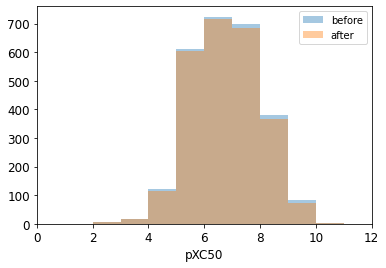

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()

# This will be our before curation
before=data["pXC50"]

# current curated dataframe will not include any out of range values
after=curated_df["pXC50"]

sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')
plt.legend()
ax.set_xlim([0, 12])

## Let us cluster the compounds to explore the chemical space


Project compounds into two dimensions with UMAP and Tanimoto similiarty

1.   Cluster compounds by Tanimoto similarity
2.   Repeat steps 1 and 2 with Maximum Common Substructure distance when dataset size is below # threshold (default < 300)

See documentation here:
 https://ampl.readthedocs.io/en/latest/pipeline.html?highlight=diversity_plots#pipeline.diversity_plots.diversity_plots

 </li>

# Save output from clustering heatmap to image and upload to presentation

In [31]:
# ifile=tmp_dir+target_name+'_excape.csv.'+username
ifile="frac_excape.csv"

# Plot self similarity (Tanimoto) within dataset and show distribution of distances between compounds in dataset for nearest neighbor.

## Save  distribution plot as an image.

We will be calling dp.diversity_function from AMPL in the following code chunk. For AMPL function explanations, 
please consult AMPL documentation here, https://ampl.readthedocs.io/en/latest/pipeline.html?highlight=diversity_plots#pipeline.diversity_plots.diversity_plots 

## Here is a brief explanation of `dp` function: 

### The AMPL function will calculate diversity profile for the data. 

### Input Args:


*   **dset_key:** : Name of the input data variable 
*   **datastore** : 
*   **id_col**    : Ambit_InchiKey, it is a chemical identifier for the compound or drug molecules. Please check here for a detailed explanation of InChiKey, https://en.wikipedia.org/wiki/International_Chemical_Identifier#:~:text=%2B%2Fm0%2Fs1-,InChIKey,hashed%20counterpart%20of%20standard%20InChI. In this case, Excape is using InChiKey generated from Ambit
*   **response_col**: Outcome column, in out case it is pXC50

## `dp.diversity_plots` function

*    Computes Fingerprints 
*    If the number of compounds are > 300, it will compute Fingerprints and use it to compute Tanimoto distance matrix. plot the distances using UMAP projection and cluster (complete cluster method will be used) the distances to create a heatmap
*   If the number of compounds are < 300, MCS (Maximum Common Substructure) will be in addition the above step. 


## Helpful links

* Tanimoto 
    * https://en.wikipedia.org/wiki/Jaccard_index
    * https://en.wikipedia.org/wiki/Chemical_similarity
* UMAP
    * https://pair-code.github.io/understanding-umap/
* MCS
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2718661/ 

In [32]:
x_del = pd.read_csv(ifile)

In [33]:
x_del.columns

Index(['compound_id', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES', 'base_rdkit_smiles', 'VALUE_NUM_mean',
       'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate'],
      dtype='object')

Canonicalizing 2585 molecules...
Done
Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


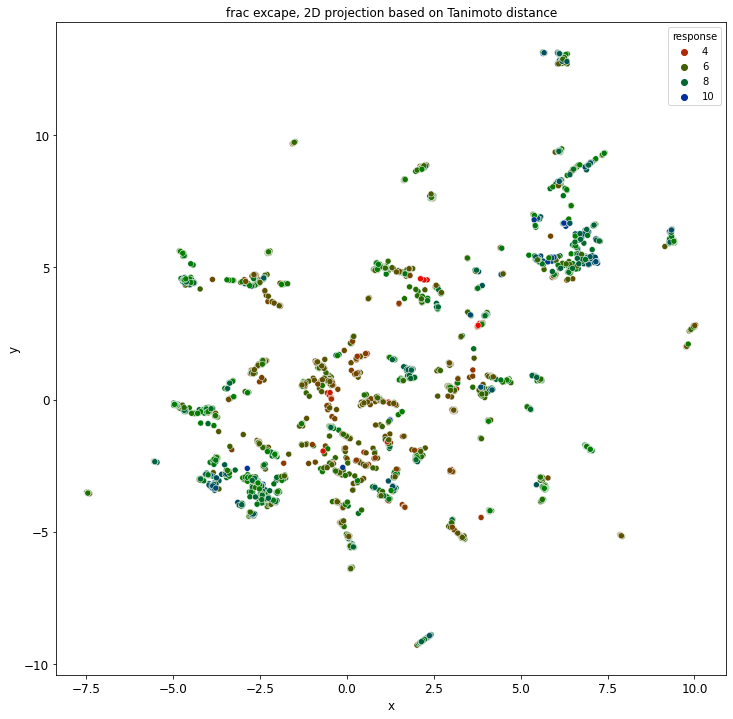

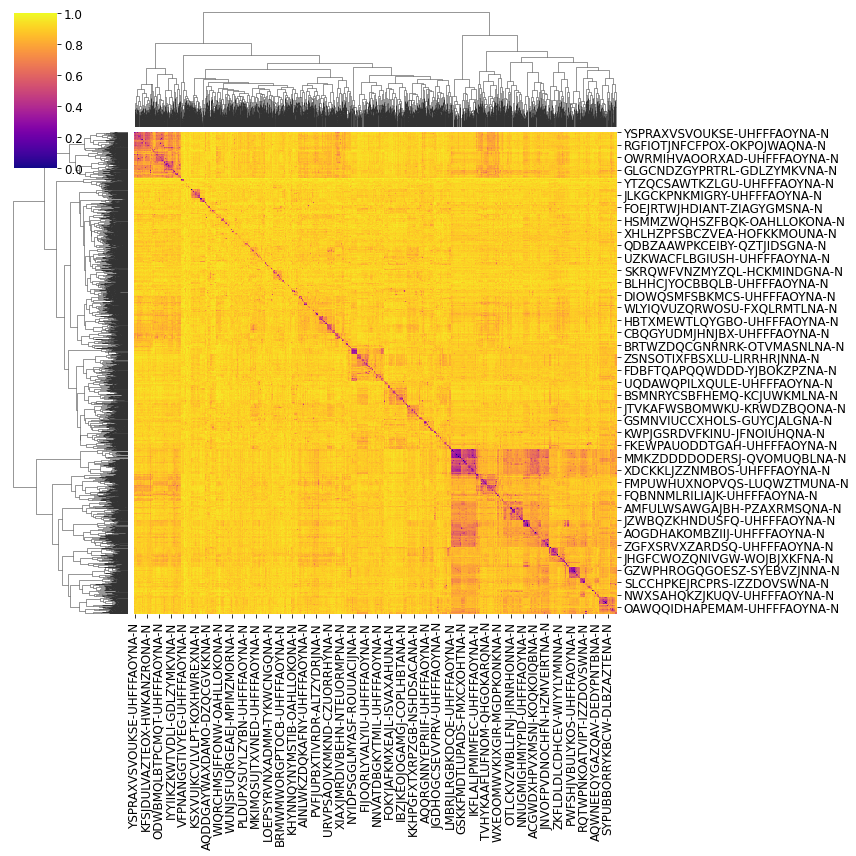

In [36]:
dp.diversity_plots(dset_key=ifile,datastore=False,id_col='compound_id',response_col='pXC50',smiles_col = 'base_rdkit_smiles')

## Self similarity (Tanimoto) 

Calculate self-similarity (using Tanimoto) for the dataset and plot the distanes. 

In [37]:
feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = save_smiles_df['base_rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)

In [38]:
print(len(dist_sample))
print(len(smiles_lst1))

2646
2646


## What does **calc_dist_smiles** function return? 


*   input is a list of SMILES strings
*   data featurization: ECFP (Fingerprint)
*   What distance metric to use? Tanimoto
*   How to process distance matrix, nearest ?
*   returns a distance matrix as a vector of distances

Here is the function summary:

*   rdkit is used to transform SMILES to mols
*   mols to FP (Morgan, 1024 FP)
*   calls calc_summary with the following options: 
         * fprints1 is the FP 
         * fprints2 is none 
         * dist_metrics will return a distance matrix
    calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type=nearest, num_nearest=1, within_dset=True)

* Finally, returns the distances of each atom to its closest neighbor 



## Explanation for the following code chunk

* **scipy.stats.kde** will use kernel density function to estimate the probability density function (PDE)
---



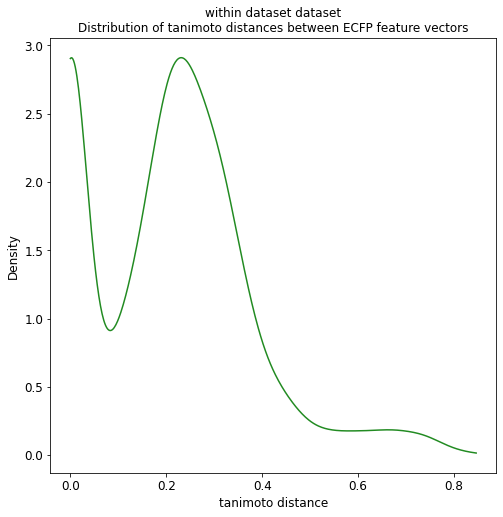

In [40]:
from scipy.stats.kde import gaussian_kde

# import math library
import numpy as np

# for creating plots
import matplotlib.pyplot as plt

# current directory
odir='./'

# name for the task
task_name='within dataset'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')

In [41]:
!date # ending time

Wed Mar 17 21:44:03 UTC 2021
